# Game of life

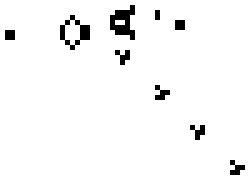

A single Gosper's glider gun 🙂

[The Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) (Life) is a zero-player game in which cluster of cells evolve over time. At the start the user provides the initial configuration of the cells, usually "painting" the cells over the map. For that point on the game loop starts and no further interactions are possible. In each epoch the cells either spawn, live or perish according to a set of immutable rules.

1. Any live cell with fewer than two live neighbours dies, as if by underpopulation.
2. Any live cell with two or three live neighbours lives on to the next generation.
3. Any live cell with more than three live neighbours dies, as if by overpopulation.
4. Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.


Cells  usually live in a 2D grid-like infinite platform, but there exists also variants. In one such cases, cells evolve on a [toroidal-shaped world](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life#/media/File:Trefoil_knot_conways_game_of_life.gif). Simply put, when cells reach the borders of the grid, they spawn on the opposite side.

In this tutorial, however, we will implement a simple 64x64 squared map. As a consequence, cells on the borders will have less neighbors than central cells.


## Example of patterns
We can group together patterns of cells that share similar behaviour.

- **Still lifes**: these are groups of cells that will indefinitely remain in the starting position unless perturbated by any other cells. In this category we can find the **Block**, the **Boat** and the **Tube**.

- **Oscillators**: these patterns return to the original configuration after a finite number of generations, like a pendulum. The most common oscillators have a period of 2. Here we can find the **Blinker**, the **Toad**, and the choreographic **Pulsar**.

- **Spaceships**: in this category we can find patterns that "move" across the map, indeed like spacecrafts. We range from the very simple yet elegant **Glider** to the vessel-shaped **Heavy-weight spaceship**.


In [1]:
# ---------- STILL LIFES ----------
def block(origin, world):
  i, j = origin

  world[i, j] = True
  world[i+1, j] = True
  world[i, j+1] = True
  world[i+1, j+1] = True

def beacon(origin, world):
  i, j = origin

  world[i, j+1] = True
  world[i+1, j+1] = True
  world[i+1, j] = True

  world[i-2, j-1] = True
  world[i-2, j-2] = True
  world[i-1, j-2] = True

# ---------- OSCILLATORS ----------
def blinker(origin, world):
  i, j = origin

  world[i, j-1] = True
  world[i, j] = True
  world[i, j+1] = True

# ---------- SPACESHIPS ----------
def glider(origin, world):
  i, j = origin

  world[i-1, j] = True
  world[i, j+1] = True
  world[i+1, j+1] = True
  world[i+1, j] = True
  world[i+1, j-1] = True

def lwss(origin, world):
  i, j = origin

  world[i-1,j+2] = True
  world[i,j+2] = True
  world[i+1,j+2] = True
  world[i+1,j+1] = True
  world[i+1,j] = True
  world[i+1,j-1] = True
  world[i,j-2] = True
  world[i-2,j-2] = True
  world[i-2,j+1] = True


## Rules 📚

1. Any live cell with fewer than two live neighbours dies, as if by underpopulation.
2. Any live cell with two or three live neighbours lives on to the next generation.
3. Any live cell with more than three live neighbours dies, as if by overpopulation.
4. Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.


In [2]:
def live_or_die(cell_pos, world):
  '''
  === Arguments ===
  cell_pos:   coordinates of the cell (x,y)
  world:      the current populated world

  === Returns ===
  1:          cell at x,y is active
  0:          cell at x,y is out

  === Descritpion ===
  According to the set of rules, the function decides
  whether a cell must live or perish in the next generation
  '''
  i, j = cell_pos
  dim_i, dim_j = world.shape
  neighbours = 0

  # Horizontal top (0-3)

  off_left = -1
  off_right = 2
  if i != 0:                                      # No on top
    if j == 0:                                    # Is on left border
      off_left = 0
    elif j == dim_j-1:                            # Is on right border
      off_right= 1
    neighbours += np.sum(world[i-1,j+off_left:j+off_right])

  # Horizontal bottom (0-3)
  off_left = -1
  off_right = 2
  if i != dim_i-1:                                # No on bottom
    if j == 0:                                    # Is on left border
      off_left = 0
    elif j == dim_j-1:                            # Is on right border
      off_right = 1
    neighbours += np.sum(world[i+1,j+off_left:j+off_right])

  # Left cell
  if j != 0:
    neighbours += world[i, j-1]

  # Right cell
  if j != dim_j-1:
    neighbours += world[i, j+1]

  # Cell is alive
  if world[cell_pos]:
    # Rule 1 (die for underpopularion)
    if neighbours < 2:
      return 0
    # Rule 2 (live)
    elif neighbours == 2 or neighbours == 3:
      return 1
    # Rule 3 (die for overpopulation)
    else:
      return 0

  # Cell is dead
  else:
    # Rule 4 (live by reproduction)
    if neighbours == 3:
      return 1
    return 0


## Initial configuration
To test the program, we create an empty world of a given size; then, we populate it with random configurations using the above functions.

Note: the patters will override the existing cells on the world map.

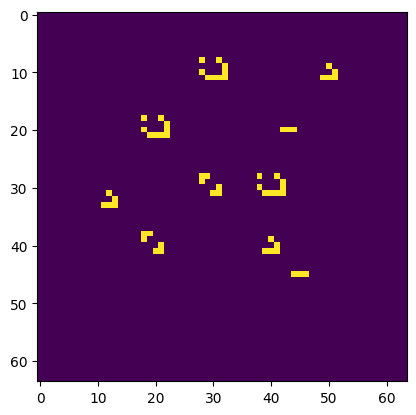

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def get_empty_world(dim_i, dim_j):
  return np.zeros((dim_i,dim_j), dtype=bool)

def get_dummy_world(dim_i, dim_j):
  world = get_empty_world(dim_i, dim_j)

  glider((32, 12), world)
  glider((40, 40), world)
  glider((10, 50), world)

  lwss((10,30), world)
  lwss((20,20), world)
  lwss((30,40), world)

  blinker((20,43), world)
  blinker((45,45), world)

  beacon((30,30), world)
  beacon((40,20), world)

  return world

dummy_world = get_dummy_world(64, 64)
plt.imshow(dummy_world)
plt.show()

## Game Loop

- The `epochs` parameter establish the number of generations.
- `history` is a matrix of shape `(dim,dim,epochs)` that keeps in memory the evolution of the cells; here we will store intermediate generations.
- To calculate the next state we leverage on an auxiliary matrix, `old_world`, on which the rules will be effective

In [5]:
def game_loop(epochs, init_world):
  '''
  === Arguments ===
  epochs:         number of generations
  init_world:     initial game world

  === Returns ===
  history:        a 3D matrix

  === Descritpion ===
  Computes the evolution of the game, looping
  through all the indexes for all the epochs

  '''
  dim_i, dim_j = init_world.shape
  history = np.zeros((dim_i,dim_j,epochs), dtype=bool)
  history[:,:,0] = init_world
  old_world = init_world

  for e in range(epochs):
    new_world = np.zeros((dim_i,dim_j), dtype=bool)

    for i in range(1, dim_i-1, 1):
      for j in range(1, dim_j-1, 1):
        status = live_or_die((i,j), old_world)     # 'live', 'die'
        new_world[i,j] = status

    history[:,:,e] = new_world
    old_world = new_world

    if e % 10 == 0:
      print(f'{e}/{epochs} generation reached')

  print('\nEnd of generation')
  return history


In [6]:
history = game_loop(120, dummy_world)

0/120 generation reached
10/120 generation reached
20/120 generation reached
30/120 generation reached
40/120 generation reached
50/120 generation reached
60/120 generation reached
70/120 generation reached
80/120 generation reached
90/120 generation reached
100/120 generation reached
110/120 generation reached

End of generation


## Output 😵

Let's now generate the final animation!

In [7]:
from matplotlib.animation import FuncAnimation


In [12]:
def generate_animation(frames, name):

  def update(frame):
    plt.clf()  # Clear the previous frame
    plt.imshow(history[:,:,frame])  # Display the current frame

  fig, ax = plt.subplots()
  animation = FuncAnimation(fig, update, frames=frames.shape[-1], repeat=False)
  animation.save(f'out/{name}.gif', writer='pillow')
  print(f'{name}.gif saved in current directory!')


In [ ]:

generate_animation(history, 'dummy_animation')


## Other interesting patterns 🛸

In [10]:
def acorn(origin, world):
  '''
  Acorn takes 5206 generations to generate 633 cells,
  including 13 escaped gliders.
  '''
  i, j = origin

  world[i,j] = True
  world[i+1,j+1] = True
  world[i+1,j+2] = True
  world[i+1,j+3] = True

  world[i-1,j-2] = True
  world[i+1,j-2] = True
  world[i+1,j-3] = True

def gosper_glider_gun(origin, world):
  i, j = origin

  world[i,j] = True
  world[i+1,j] = True
  world[i,j+1] = True
  world[i+1,j+1] = True

  world[i,j+10] = True
  world[i+1,j+10] = True
  world[i+2,j+10] = True

  world[i+3,j+11] = True
  world[i-1,j+11] = True

  world[i+4,j+12] = True
  world[i+4,j+13] = True
  world[i-2,j+12] = True
  world[i-2,j+13] = True

  world[i+1,j+14] = True
  world[i-1,j+15] = True
  world[i,j+16] = True
  world[i+1,j+16] = True
  world[i+2,j+16] = True
  world[i+1,j+17] = True
  world[i+3,j+15] = True

  world[i,j+20] = True
  world[i,j+21] = True
  world[i-1,j+20] = True
  world[i-1,j+21] = True
  world[i-2,j+20] = True
  world[i-2,j+21] = True
  world[i-3,j+22] = True

  world[i-3,j+24] = True
  world[i-4,j+24] = True

  world[i+1,j+24] = True
  world[i+2,j+24] = True
  world[i+1, j+22] = True

  world[i-1,j+34] = True
  world[i-2,j+34] = True
  world[i-1,j+35] = True
  world[i-2,j+35] = True

In [ ]:
# === Acorn test ===

w1 = get_empty_world(100,100)
acorn((50,80),w1)
history = game_loop(100, w1)
generate_animation(history, 'acorn')

In [ ]:
# === Gosper Glider Gun test ===

w1 = get_empty_world(64,64)
gosper_glider_gun((20,5),w1)
history = game_loop(200, w1)
generate_animation(history, 'gosper_gun')